# CIL Challenge 1: Collaborative Filtering

## Overview

The challenge consists of reading a series of data points representing
ratings users gave to some items, and predicting all other ratings in the
user-item rating matrix, using various techniques, most of which are based
on SVD (Singular Value Decomposition).

## TODO and Ideas
 * Try out iterative SVD (Nikos' idea).
 * Try out regularized SGD (see news article linked in exercise sheet on CF in practice and the Netflix prize).
 * Try to improve SGD using biases (user bias, item bias).
 * Try out k-means (should perform worse technically).
 * Try to combine k-means with SVD.

## Data Wrangling

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import copy
import random

In [2]:
def full_svd(matrix):
    """Utility which returns full SVD matrices.
    
    Works around the fact that numpy's SVD function returns the 'd'
    as a vector of singular values, instead of a diagonal matrix.
    """
    U, d, V = np.linalg.svd(matrix, full_matrices=True)
    D = np.zeros(matrix.shape)
    D[:d.shape[0],:d.shape[0]] = np.diag(d)
    return U, D, V

In [3]:
def load_ratings(data_file):
    """Loads the rating data from the specified file. 
    
    Does not yet build the rating matrix. Use 'ratings_to_matrix' to do that.
    Assumes the file has a header (which is ignored), and that the ratings are
    then specified as 'rXXX_cXXX,X', where the 'X' blanks specify the row, the
    column, and then the actual (integer) rating.
    """
    ratings = []
    with open(data_file, 'r') as file:
        header = file.readline()
        # print("Header: %s" % header)
        for line in file:
            key, value_string = line.split(",")
            rating = int(value_string)
            row_string, col_string = key.split("_")
            row = int(row_string[1:])
            col = int(col_string[1:])
            
            if rating < 1 or rating > 5:
                raise ValueError("Found illegal rating value [%d]." % rating)
            
            ratings.append((row - 1, col - 1, rating))
            
    return ratings

def ratings_to_matrix(ratings, matrix_rows, matrix_cols):
    """Converts a list of ratings to a numpy matrix."""
    print("Building [%d x %d] rating matrix." % (matrix_rows, matrix_cols))
    matrix = np.zeros([matrix_rows, matrix_cols])
    for (row, col, rating) in ratings:
        matrix[row, col] = rating
        
    print("Finished building rating matrix.")
    return matrix

In [4]:
# Rows are users
USER_COUNT = 10000

# Columns are items
ITEM_COUNT = 1000

VALIDATION_RATIO = 0.1
TRAINING_RATIO = 1 - VALIDATION_RATIO

In [5]:
RANDOM_SEED = 0xC0FFEE
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [6]:
all_ratings = load_ratings('data/cf/data_train.csv')

In [7]:
data_matrix = ratings_to_matrix(all_ratings, USER_COUNT, ITEM_COUNT)

Building [10000 x 1000] rating matrix.
Finished building rating matrix.


In [8]:
all_ratings_count = len(all_ratings)
print("We have [%d] data points." % all_ratings_count)

validation_count = int(VALIDATION_RATIO * all_ratings_count)
training_count = all_ratings_count - validation_count
print("Will use [%d] data points for validation, and [%d] for training." %
     (validation_count, training_count))

We have [1388107] data points.
Will use [138810] data points for validation, and [1249297] for training.


In [9]:
def shuffle_split_data(all_data, training_count, validation_count):
    """Returns a split consisting of (training, validation) data, created
    after shuffling the input data.
    """
    to_shuffle = copy.copy(all_data)
    random.shuffle(to_shuffle)
    return to_shuffle[:training_count], to_shuffle[training_count:]

In [10]:
train, validation = shuffle_split_data(all_ratings, training_count, validation_count)
train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
validation_matrix = ratings_to_matrix(validation, USER_COUNT, ITEM_COUNT)

assert len(train_matrix[train_matrix != 0]) == training_count
assert len(validation_matrix[validation_matrix != 0]) == validation_count

Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.


In [11]:
def score_predictions(prediction_matrix, validation_matrix):
    """Computes the RMSE score for the prediction matrix based
    on the data points present in the validation matrix.
    
    """
    
    # Want to compute RMSE just for nonzero validation elements.
    mask = (validation_matrix != 0)
    count = np.sum(mask)
    actual = prediction_matrix[mask]
    real = validation_matrix[mask]
    
    delta = np.abs(actual - real)
    delta = delta * delta
    delta = np.sum(delta)
    
    score = np.sqrt(delta / count)
    return score


def score_predictions_slow(prediction_matrix, validation_matrix):
    s = 0
    count = 0 #np.sum(validation_matrix > 0)
    for row in range(validation_matrix.shape[0]):
        for col in range(validation_matrix.shape[1]):
            if validation_matrix[row, col] > 0:
                delta = (validation_matrix[row, col] - prediction_matrix[row, col]) ** 2
                s += delta
                count += 1
                
    score = np.sqrt(s * 1.0 / count)
    return score

In [12]:
def predict_by_avg_avg(data):
    """Imputation by averaging mean user and mean item rating in every cell.
    
    """
    
    # These are the indices of the cells where we have no data.
    to_impute = (data == 0)
    if np.sum(to_impute) == 0:
        raise ValueError("Sanity check: found no values for imputation!")
        
    item_pred = predict_by_avg(data, averaging=0)
    user_pred = predict_by_avg(data, averaging=1)
    
    avg_pred = (item_pred + user_pred) / 2
    prediction = np.copy(data)
    
    # Only update the data that were missing to begin with.
    for (i, row) in enumerate(prediction):
        row[row == 0] = avg_pred[i, row == 0]
    return prediction
    
    
def predict_by_rating_avg(data):
    """Imputation by average rating in the whole system."""
    # TODO(andrei) Median? Percentiles?
    mean_rating = np.mean(data[data != 0])
    prediction = np.copy(data)
    prediction[data == 0] = mean_rating
    return prediction
    

def predict_by_avg(data, averaging=0):
    """Performs naive data imputation.
    
    Arguments:
        data: The numpy data matrix on which to operate.
        averaging: Enum specifying how to average:
            0: perform column averaging (avg. item rating)
            1: perform row averaging (avg. user rating)
            
    Returns:
        An updated copy of the original matrix.
    """
    
    nonzero = (data != 0)
    rating_mean = np.mean(data[nonzero])
    
    # Sum on the 0th axis => per-item ratings.
    # Sum on the 1st axis => per-user ratings.
    if averaging == 0:
        axis = 0
    elif averaging == 1:
        axis = 1
    else:
        raise ValueError("Unknown averaging type [%s]." % str(averaging))
        
    rating_counts = nonzero.sum(axis)
    rating_sums = data.sum(axis)
    avg_ratings = rating_sums / rating_counts
    # Prevent NaNs for users/entities with no ratings, and just put
    # the overall mean in there!
    avg_ratings[np.isnan(avg_ratings)] = rating_mean
    predictions = np.copy(data)
    
    print("Got %d average ratings." % len(avg_ratings))
    
    if averaging == 0:
        for col in range(data.shape[1]):
            no_rating = (predictions[:, col] == 0)
            predictions[no_rating, col] = avg_ratings[col]
    else:
        for row in range(data.shape[0]):
            no_rating = (predictions[row, :] == 0)
            predictions[row, no_rating] = avg_ratings[row]

    zero_pred = (predictions == 0)
    assert np.sum(zero_pred) == 0
    return predictions
    

def predict_by_avg_item_rating(data):
    return predict_by_avg(data, averaging=0)


def predict_by_avg_user_rating(data):
    return predict_by_avg(data, averaging=1)


item_impute = predict_by_avg_item_rating(train_matrix)
user_impute = predict_by_avg_user_rating(train_matrix)
mean_user_item_impute = predict_by_avg_avg(train_matrix)
mean_impute = predict_by_rating_avg(train_matrix)

print("Mean rating RMSE: %.4f" % score_predictions(mean_impute, validation_matrix))
print("User rating RMSE: %.4f" % score_predictions(user_impute, validation_matrix))
print("Item rating RMSE: %.4f" % score_predictions(item_impute, validation_matrix))
print("Mean user and item rating RMSE: %.4f" % score_predictions(mean_user_item_impute, validation_matrix))

print("NaNs: %d" % np.sum(np.isnan(user_impute)))

# print("RMSE: %.4f" % score_predictions_slow(no_svd_result, validation_matrix))

Got 1000 average ratings.
Got 10000 average ratings.
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Mean rating RMSE: 1.1211
User rating RMSE: 1.0853
Item rating RMSE: 1.0312
Mean user and item rating RMSE: 1.0254
NaNs: 0


In [13]:
def svd_predict(data, k=290, sanity_check=False):
    """Predict the missing values in the data matrix using SVD.
    
    Imputes the missing values using column-wise means, and then improves the
    prediction using singular value decomposition.
    
    Arguments:
        data: The data matrix with missing values on which to apply SVD.
        k: The number of singular values to keep.
        sanity_check: Whether to perform additional (potentially slow) sanity checks.
    """
    # Note: this function does not apply the 'sqrt(D)' pre-multiplication
    # trick specified in the exercise sheet, as it led to a strange (and
    # likely silly) bug.
    
    imputed = predict_by_avg_avg(data)
    U, d, V = np.linalg.svd(imputed, full_matrices=True)
    # This ensures that our variables correspond with the notation in
    # the slides and homework sheets.
    V = V.T
    D = np.zeros_like(imputed)
    D[:d.shape[0], :d.shape[0]] = np.diag(d)
    
    if sanity_check:
        reconstruction = np.dot(U, np.dot(D, V.T))
        assert np.allclose(reconstruction, imputed)

    U_lim = U[:,:k]
    D_lim = D[:k, :]
    V_lim = V[:, :]
    k_prediction = np.dot(U_lim, np.dot(D_lim, V_lim.T))
    k_prediction = k_prediction[:, :1000]
    
    return k_prediction

In [14]:
# Reuse previous prediction
imputed = mean_user_item_impute

U, d, V = np.linalg.svd(imputed, full_matrices=True)
V = V.T

In [15]:
D = np.zeros_like(imputed)
D[:d.shape[0], :d.shape[0]] = np.diag(d)

In [16]:
# A few sanity checks for various values of k (singular values kept).

errors = []
means = []
ks = range(10, 1000, 25)
for k in ks:
    U_k = U[:, :k]
    D_k = D[:k, :]
    V_k = V[:, :]

    recon_k = np.dot(U_k, np.dot(D_k, V_k.T))
    fro = np.linalg.norm(recon_k - imputed)
    errors.append(fro)
    means.append(np.mean(recon_k))

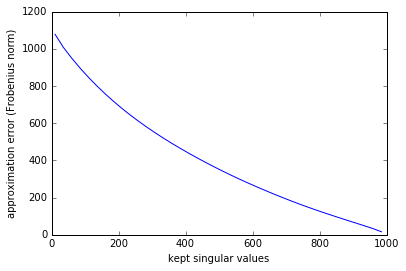

In [17]:
plt.plot(ks, errors)
plt.xlabel("kept singular values")
plt.ylabel("approximation error (Frobenius norm)")

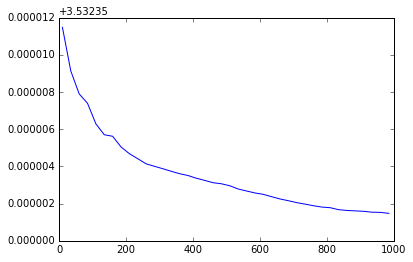

In [18]:
# Sanity
plt.plot(ks, means)

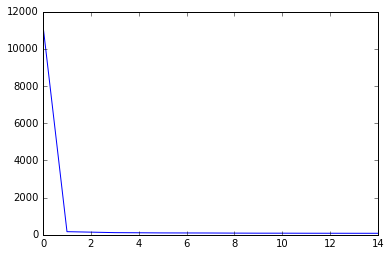

In [19]:
# Plot the singular value spectrum
plt.plot(np.arange(15), d[:15])

In [20]:
rmses = []
for k in range(5, 50, 1):
    U_lim = U[:,:k]
    D_lim = D[:k, :]
    V_lim = V[:,:]

    k_prediction = np.dot(U_lim, np.dot(D_lim, V_lim.T))
    k_prediction = k_prediction[:, :1000]
    rmses.append((k, score_predictions(k_prediction, validation_matrix)))

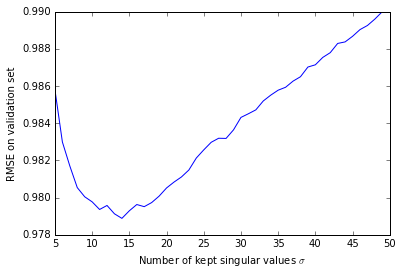

In [21]:
plt.plot([e[0] for e in rmses], [e[1] for e in rmses])
plt.xlabel("Number of kept singular values $\sigma$")
plt.ylabel("RMSE on validation set")

# Cross-validation (experimental)

In [22]:
from sklearn.cross_validation import KFold

In [23]:
CV_FOLDS = 5
folds = KFold(len(all_ratings), n_folds=CV_FOLDS, shuffle=True)

# TODO(andrei) Implement predictions as a subclass of BaseEstimator
# and/or RegressionEstimator so we can use it with e.g. grid searches.

k = 3

# A 2D array where every row is a data point. The first column specifies
# the row in the data matrix where the rating belongs, the second column,
# its column. The third one is the actual rating.
all_ratings_np = np.array(all_ratings)
all_ratings_np.shape

(1388107, 3)

In [24]:
# We will not use 'svd_predict' and instead we will use a dirty trick
# to significantly speed up our cross-validation scores.

# For every fold, results will contain a list of len(ks) scores.
# This is an unorthodox way of doing CV, but it's much faster since
# we only do one SVD per fold, instead of one per (k * folds).
results = []

ks = range(1, 30, 1)
#imputation_fn = predict_by_avg_item_rating
imputation_fn = predict_by_avg_avg
for train_index, test_index in folds:
    train = all_ratings_np[train_index]
    test = all_ratings_np[test_index]
     
    train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
    test_matrix = ratings_to_matrix(test, USER_COUNT, ITEM_COUNT)
    
    #print("Performing imputation...")
    imputed = imputation_fn(train_matrix)
    if len(imputed[np.isnan(imputed)]):
        raise ValueError("Found NaNs in imputed data. Aborting.")
    
    #print("Performing SVD...")
    U, d, V = np.linalg.svd(imputed, full_matrices=True)
    #print("SVD done.")
    V = V.T

    D = np.zeros_like(imputed)
    D[:d.shape[0], :d.shape[0]] = np.diag(d)

    rmses = []
    for k in ks:
        U_k = U[:, :k]
        D_k = D[:k, :]
        V_k = V[:, :]
        
        k_prediction = np.dot(U_k, np.dot(D_k, V_k.T))
        k_prediction = k_prediction[:, :1000]
        rmses.append((k, score_predictions(k_prediction, test_matrix)))

    results.append(rmses)
    
print("Done.")

Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished buil

In [25]:
cv_rmses = []
for index, k in enumerate(ks):
    score = 0
    for fold in range(CV_FOLDS):
        score += results[fold][index][1]
        
    avg_score = score / CV_FOLDS
    cv_rmses.append(avg_score)

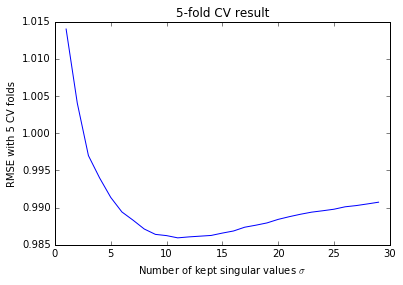

In [26]:
plt.plot(ks, cv_rmses)
plt.ylabel("RMSE with %d CV folds" % CV_FOLDS)
plt.xlabel("Number of kept singular values $\sigma$")
plt.title("%d-fold CV result" % CV_FOLDS)

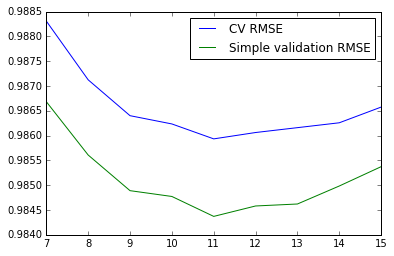

In [27]:
plt.plot(ks[6:15], cv_rmses[6:15], label="CV RMSE")
plt.plot([e[0] for e in rmses][6:15], [e[1] for e in rmses][6:15], label="Simple validation RMSE")
plt.legend()

# K-means Approach

In [50]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def kmeans_predict(data, n_clusters, impute=predict_by_avg_avg, **kw):
    imputed = impute(data, **kw)
    
    # From docs: Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.
    # Note: regular KMeans is not much slower.
    kmeans = MiniBatchKMeans(n_clusters=n_clusters)
    
    # This clusters the users based on their item ratings.
    # The individual product ratings are the "dimensions" of each data point.
    # Possible issue: data **very** sparse.
    kmeans.fit_predict(imputed)
        
    labels = kmeans.labels_
    cc = kmeans.cluster_centers_
    cluster_mean_ratings = np.mean(cc, axis=1)
    mean_replace = cluster_mean_ratings[labels]
        
    # For all users, replace their missing ratings by the average
    # of the real ratings of all other users in that cluster.
    
    cluster_real_ratings = {label: [] for label in range(n_clusters)}
    for index, row in enumerate(data):
        # A row is a user.
        
        label = labels[index]
        for rating in row[row != 0]:
            cluster_real_ratings[label].append(rating)
        
    cluster_real_means = {label: np.mean(np.array(cluster_real_ratings[label]))
                          for label in cluster_real_ratings}
#     print(cluster_real_means)
    
    # TODO(andrei) Vectorize more of the code.
    prediction = np.copy(data)
    for user_label, prow in zip(labels, prediction):
        prow[prow == 0] = cluster_real_means[user_label]
        
    return prediction


cluster_counts = range(2, 60, 6)
kmeans_results = []
for train_index, test_index in folds:
    train = all_ratings_np[train_index]
    test = all_ratings_np[test_index]
     
    train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
    test_matrix = ratings_to_matrix(test, USER_COUNT, ITEM_COUNT)
    
    rmses = []
    for cc in cluster_counts:
        pred = kmeans_predict(train_matrix, cc)
        rmse = score_predictions(pred, test_matrix)
        rmses.append(rmse)
    
    kmeans_results.append(rmses)

Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] 

In [46]:
# TODO(andrei) Utility function for this.

kmeans_cv_rmses = []
for index, k in enumerate(cluster_counts):
    score = 0
    for fold in range(CV_FOLDS):
        score += kmeans_results[fold][index]
        
    avg_score = score / CV_FOLDS
    kmeans_cv_rmses.append(avg_score)

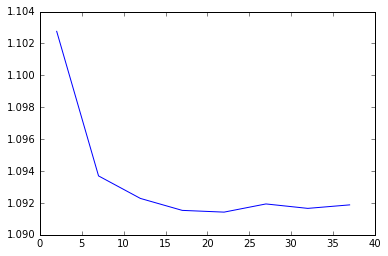

In [49]:
plt.plot(cluster_counts, kmeans_cv_rmses)
# RMSE seems to be much higher than any SVD solution (5-fold CV)

# Successive SVDs

Based on Nikos' suggestion.

In [59]:
def multiple_svds(filled_matrix, initial_data, k, rounds):
    rmse = []
    print("multiple svds.")
    print("rmse for different rounds")
    for i in range(1, rounds + 1):
        print("SVD round [%d]" % i)
        U, d, VT = np.linalg.svd(filled_matrix, full_matrices=False)
        D = np.diag(d)
        U_prime = np.dot(U, np.sqrt(D))
        VT_prime = np.dot(np.sqrt(D), VT)
        U_lim = U_prime[:,:k] #only first k columns
        VT_lim = VT_prime[:k, :] #only first k rows

        k_prediction = np.dot(U_lim, VT_lim)
        k_prediction[initial_data != 0] = 0 #make zero all the cells that I know their value

        filled_matrix = k_prediction + initial_data
        error = score_predictions(filled_matrix, validation_matrix)

        rmse.append(error) 
        print("%d: %.6f" % (i, error))

    plt.plot(range(1,rounds+1), rmse, label="k = %d, rounds = %d" % (k, rounds))
    plt.xlabel("number of successive svds")
    plt.ylabel("rmse error on validation cells")
    return filled_matrix

Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
multiple svds.
rmse for different rounds
SVD round [1]
1: 0.442774
SVD round [2]
2: 0.439836
SVD round [3]
3: 0.438559
SVD round [4]
4: 0.437780
SVD round [5]
5: 0.437237
SVD round [6]
6: 0.436832
SVD round [7]
7: 0.436519
SVD round [8]
8: 0.436269
SVD round [9]
9: 0.436067
SVD round [10]
10: 0.435900
SVD round [11]
11: 0.435760
SVD round [12]
12: 0.435642
SVD round [13]
13: 0.435542
SVD round [14]
14: 0.435456
SVD round [15]
15: 0.435381
SVD round [16]
16: 0.435316
SVD round [17]
17: 0.435259
SVD round [18]
18: 0.435209
SVD round [19]
19: 0.435165
SVD round [20]
20: 0.435125
SVD round [21]
21: 0.435090
SVD round [22]
22: 0.435059
SVD round [23]
23: 0.435030
SVD round [24]
24: 0.435004
SVD round [25]
25: 0.434981
multiple svds.
rmse for different rounds
SVD round [1]
1: 0.441315
SVD round [2]
2: 0.438216
SVD round [3]
3: 0.436984
SVD round [4]
4: 0.436284
SVD round [5]
5: 0.435821
SVD round [

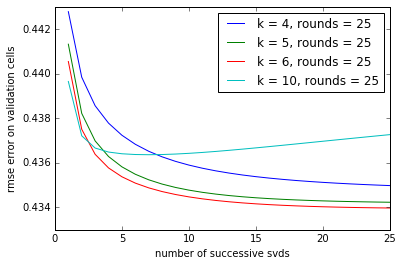

In [61]:
imputed = predict_by_avg_avg(train_matrix)
multi_svd_result_5 = multiple_svds(imputed, train_matrix, 4, 25)
multi_svd_result_5 = multiple_svds(imputed, train_matrix, 5, 25)
multi_svd_result_5 = multiple_svds(imputed, train_matrix, 6, 25)
multi_svd_result_10 = multiple_svds(imputed, train_matrix, 10, 25)
#multi_svd_result_11 = multiple_svds(imputed, train_matrix, 11, 10)
# multi_svd_result_13 = multiple_svds(imputed, train_matrix, 13, 10)
plt.legend()

# Kaggle test data output stuff

multiple svds.
rmse for different rounds
SVD round [1]
1: 0.000000
SVD round [2]
2: 0.000000
SVD round [3]
3: 0.000000
SVD round [4]
4: 0.000000
SVD round [5]
5: 0.000000
SVD round [6]
6: 0.000000
SVD round [7]
7: 0.000000
SVD round [8]
8: 0.000000
SVD round [9]
9: 0.000000
SVD round [10]
10: 0.000000
SVD round [11]
11: 0.000000
SVD round [12]
12: 0.000000
SVD round [13]
13: 0.000000
SVD round [14]
14: 0.000000
SVD round [15]
15: 0.000000
SVD round [16]
16: 0.000000
SVD round [17]
17: 0.000000
SVD round [18]
18: 0.000000
SVD round [19]
19: 0.000000
SVD round [20]
20: 0.000000


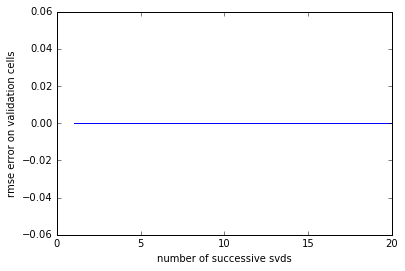

In [62]:
# test_result = svd_predict(data_matrix, k=6)
test_result = multiple_svds(imputed, data_matrix, k=6, rounds=20)

In [63]:
import os
import time

def output_solution(solution_matrix):
    submisson_template = load_ratings('data/cf/sampleSubmission.csv')
    output = "Id,Prediction\n"
    for (row, col, _) in submisson_template:
        output += "r%d_c%d,%f\n" % (row + 1, col + 1, solution_matrix[row, col])
                
    return output

def output_solution_to_file(solution_matrix, technique, output_root='out/cf'):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    file_name = "submission-%s-%s.csv" % (technique, timestr)
    file_path = os.path.join(output_root, file_name)
    with open(file_path, 'w') as output_file:
        output_text = output_solution(solution_matrix)
        output_file.write(output_text)

In [64]:
# output_solution_to_file(test_result, "vanilla-with-avg-user-and-avg-item")
output_solution_to_file(test_result, "iterative-svd-with-avg-user-and-avg-item-k-6-20-rounds")